In [1]:
import pystan
import lenskit

In [28]:
pop_unif_model_code = """
data {
    int<lower=1> U; // number of users
    int<lower=1> I; // number of items
    int<lower=1> L; // length of the recommendation list
    int<lower=0,upper=1> X[U, I];
    int<lower=0> REC_LIST[U, L];
}
parameters {
    real<lower=0> mu[I];
    real<lower=0> sigma;
    real logit_pi[U, I];
    
}
transformed parameters {
    real<lower=0, upper=1> pi[U, I];
    pi = inv_logit(logit_pi);

}
model {
    mu ~ exponential(0.001);
    sigma ~ exponential(0.001);
    
    for (u in 1:U) {
        logit_pi[u] ~ normal(mu, sigma);
    }
    
    for (u in 1:U) {
        X[u] ~ bernoulli(pi[u]);
    }
    
}
generated quantities {
    real recall[U];

    for (u in 1:U) {
        real pi_l[L];
        real n_pi;
        real k_pi;
        
        n_pi = sum(round(pi[u]));
        
        for (i in 1:L) {
            int item_id = REC_LIST[u,i] + 1;
            pi_l[i] = pi[u, item_id];
        }
        k_pi = sum(round(pi_l));
        
        recall[u] = n_pi / k_pi;
    }          
}
"""

In [2]:
import pandas as pd

In [3]:
ratings = pd.read_csv('./data/ml-100k/u.data', sep='\t', names=['user', 'item', 'rating', 'timestamp']).drop('timestamp', axis=1)

In [4]:
ratings['rel'] = 1

In [5]:
train = pd.read_csv('./build/train.csv')
test = pd.read_csv('./build/test.csv')
recommendations = pd.read_csv('./build/recommendations_item-item.csv')

Index all the items and the sample users in the recommendation lists.

In [6]:
item_index = pd.Index(ratings.item.unique())
user_index = pd.Index(recommendations.user.unique())

In [7]:
from scipy.sparse import csr_matrix

In [8]:
sample_ratings = ratings[ratings['user'].isin(recommendations['user'].unique())]

In [9]:
rows = user_index.get_indexer(sample_ratings['user'])
cols = item_index.get_indexer(sample_ratings['item'])
data = sample_ratings['rel'].values

In [10]:
nusers = len(user_index)
nitems = len(item_index)
print(nusers, nitems)

100 1682


In [11]:
csr_ratings = csr_matrix((data, (rows, cols)), shape=(nusers, nitems))

Convert sparse user-item pair to dense matrix in order to sample

In [12]:
dense_ratings = csr_ratings.toarray()

In [13]:
print(dense_ratings.shape)

(100, 1682)


In [14]:
X = dense_ratings

In [15]:
print(len(X), len(X[0]))

100 1682


In [16]:
recommendations['item_ind'] = item_index.get_indexer(recommendations['item'])

In [17]:
recommendations['user_ind'] = user_index.get_indexer(recommendations['user'])

In [18]:
REC_LIST = recommendations[['user_ind', 'item_ind', 'rank']].pivot_table(index='user_ind', columns='rank', values='item_ind').values
L = len(REC_LIST[0])

In [29]:
model_data = {'U': nusers,
              'I': nitems,
              'L': L,
              'REC_LIST':REC_LIST,
              'X': X}

sm = pystan.StanModel(model_code=pop_unif_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_76c24580e84eba3b74d54b888ec39fcb NOW.
/home/MucunTian/anaconda3/envs/eval-error/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp78ssz0qn/stanfit4anon_model_76c24580e84eba3b74d54b888ec39fcb_570564416117045396.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [19]:
import pickle as pkl

In [23]:
with open('build/pop_pref_unif_obs_model.pkl', 'wb') as f:
    pkl.dump(sm, f)

In [48]:
sm = None
with open('build/pop_pref_unif_obs_model.pkl', 'rb') as f:
    sm = pkl.load(f)

In [ ]:
fit = sm.sampling(data=model_data, iter=1000, chains=4, n_jobs=14)
# fit = sm.sampling(data=model_data, iter=2000, chains=4, n_jobs=14, control={'max_treedepth': 15})

/home/MucunTian/anaconda3/envs/eval-error/lib/python3.7/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [ ]:
la = fit.extract(permuted=True)

In [ ]:
with open('build/pop_unif_model_sampling.pkl', 'wb') as f:
    pkl.dump(la, f)

In [24]:
la_loaded = None
with open('build/pop_unif_model_sampling_1.pkl.pkl', 'rb') as f:
    la_loaded = pkl.load(f)

EOFError: Ran out of input

In [22]:
import numpy as np

In [23]:
la_loaded['pi'].shape

(2000, 20, 1682)

### Compute metrics 

In [22]:
def compute_recall(ratings, recommendations, user_col='user_ind', item_col='item_ind', rating='rating', threshold=0.5):
    rec_user_ratings = recommendations.merge(ratings, how='left', on=[user_col, item_col])
    rec_user_ratings['rel'] = rec_user_ratings[rating] > threshold
    rec_user_rel = rec_user_ratings[[user_col, 'rel']]
    rec_user_tp = rec_user_rel.groupby(user_col, as_index=False).sum()
    user_total_pos = ratings.merge(recommendations[user_col].drop_duplicates().reset_index(drop=True).to_frame(), on=user_col)
    user_total_pos['rel'] = user_total_pos[rating] > threshold
    user_total_pos = user_total_pos[[user_col, 'rel']].groupby(user_col, as_index=False).sum()
    user_recall = rec_user_tp.merge(user_total_pos, on=user_col, suffixes=('_tp', '_total_pos'))
    user_recall['recall'] = user_recall['rel' + '_tp'] / user_recall['rel' + '_total_pos']
    return user_recall['recall'].mean()

Metric on Observations

In [23]:
obs_mean_recall = compute_recall(ratings, recommendations, user_col='user', item_col='item', rating='rating')

In [24]:
print(obs_mean_recall)

0.010461499121722341


Metric on Inferences

In [25]:
la_loaded['pi'].shape

(2000, 20, 1682)

In [26]:
rec_user_ind, rec_item_ind = recommendations[['user_ind', 'item_ind']].sort_values(['user_ind', 'item_ind']).values.T

In [27]:
rec_pi = la_loaded['pi'][:, rec_user_ind, rec_item_ind].reshape((2000, 20, 100))

In [59]:
threshold = 0.4

In [60]:
rec_rel = rec_pi > threshold

In [61]:
rec_rel.shape

(2000, 20, 100)

In [62]:
rec_user_tp = np.sum(rec_rel, axis=2)

In [63]:
user_total_pos = np.sum(la_loaded['pi'] > threshold, axis=2)

In [64]:
user_recall = rec_user_tp / user_total_pos

In [65]:
infer_mean_recalls = np.mean(user_recall, axis=1)

In [66]:
mean_simulation_recall = infer_mean_recalls.mean()

In [67]:
data2plot = pd.DataFrame({"recall":infer_mean_recalls})

In [68]:
data2plot = data2plot.astype(dtype={'recall':np.float64})

In [69]:
from ggplot import *

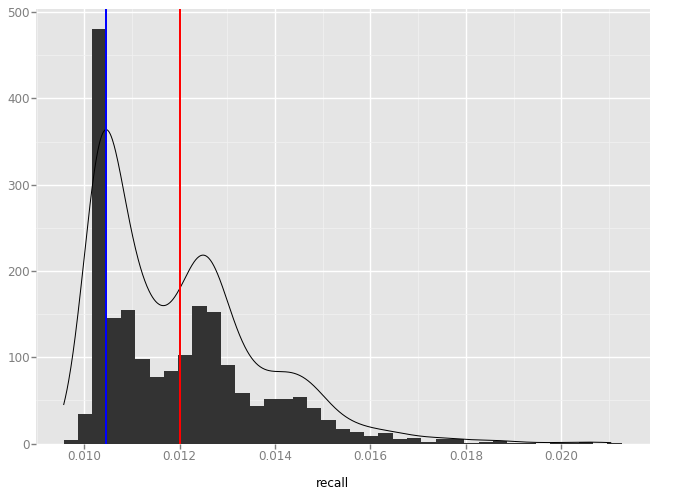

<ggplot: (-9223363267156969286)>

In [70]:
ggplot(aes(x='recall'), data=data2plot) + \
    geom_density() + \
    geom_histogram(binwidth=0.0003) +\
    geom_vline(x=mean_simulation_recall, color='red', size=2) +\
    geom_vline(x=obs_mean_recall, color='blue', size=2)

In [71]:
error = infer_mean_recalls - obs_mean_recall
error2plot = pd.DataFrame({"error":error})

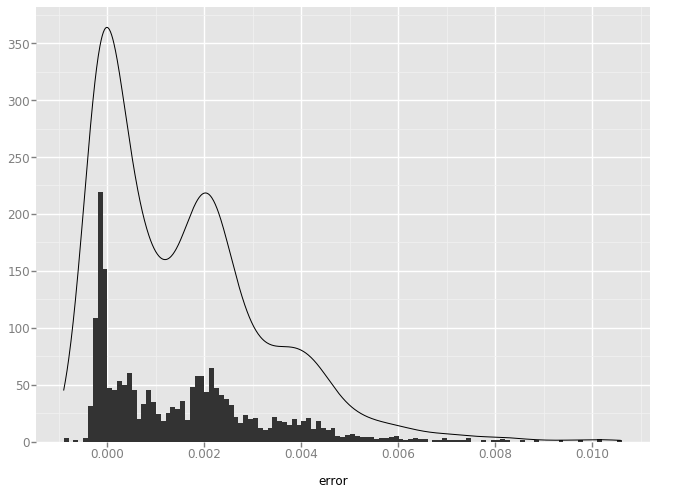

<ggplot: (-9223363267155365204)>

In [72]:
ggplot(aes(x='error'), data=error2plot) + \
    geom_density() + \
    geom_histogram(binwidth=0.0001)

In [169]:
# infer_mean_recalls = []
# for pi_mat in la_loaded['pi']:
    
#     infer_pref = pd.DataFrame.from_records(pi_mat)
#     infer_pref_tall = (infer_pref.reset_index()
#         .melt(id_vars='index', var_name='item_ind', value_name='pref')
#         .rename(columns={'index':'user_ind'}))
#     infer_pref_tall = infer_pref_tall.astype({'item_ind': np.int64})
#     infer_mean_recall = compute_recall(infer_pref_tall, recommendations, 
#                                    user_col='user_ind', item_col='item_ind', rating='pref')
#     infer_mean_recalls.append(infer_mean_recall)